In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import random

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/ml_hw3/ASIA10k_v2.csv')
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [3]:
def log_likelihood_score(variable, parents, data):
    if not parents:
        counts = data[variable].value_counts().values
        likelihood = np.sum(counts * np.log(counts + 1e-10)) - len(data) * np.log(len(data))
        return likelihood

    parent_counts = data.groupby(parents)[variable].value_counts().unstack().fillna(0)
    likelihood = 0
    for row in parent_counts.values:
        total = np.sum(row)
        if total > 0:
            likelihood += np.sum(row * np.log(row + 1e-10)) - total * np.log(total + 1e-10)
    return likelihood

def K2_algorithm(data, max_parents):
    n_variables = len(data.columns)
    parents = {var: [] for var in data.columns}

    for i in range(1, n_variables):
        current_var = data.columns[i]
        current_score = log_likelihood_score(current_var, [], data)

        while True:
            possible_parents = [p for p in data.columns[:i] if p not in parents[current_var]]
            if len(possible_parents) == 0 or len(parents[current_var]) >= max_parents:
                break

            best_parent = None
            best_score = current_score

            for parent in possible_parents:
                new_parents = parents[current_var] + [parent]
                new_score = log_likelihood_score(current_var, new_parents, data)
                if new_score > best_score:
                    best_score = new_score
                    best_parent = parent

            if best_parent is not None:
                parents[current_var].append(best_parent)
                current_score = best_score
            else:
                break

    return parents

In [4]:
models = {}

for max_p in range(1, 6):
    parents = K2_algorithm(train_data, max_p)
    models[max_p] = parents

for max_p, parents in models.items():
    print(f"max_parents = {max_p}:")
    for variable, variable_parents in parents.items():
        print(f"{variable}: {variable_parents}")

max_parents = 1:
asia: []
tub: ['asia']
smoke: ['tub']
bronc: ['smoke']
either: ['tub']
xray: ['either']
dysp: ['bronc']
lung: ['either']
max_parents = 2:
asia: []
tub: ['asia']
smoke: ['tub', 'asia']
bronc: ['smoke', 'tub']
either: ['tub', 'smoke']
xray: ['either', 'tub']
dysp: ['bronc', 'either']
lung: ['either', 'tub']
max_parents = 3:
asia: []
tub: ['asia']
smoke: ['tub', 'asia']
bronc: ['smoke', 'tub', 'asia']
either: ['tub', 'smoke', 'asia']
xray: ['either', 'tub', 'bronc']
dysp: ['bronc', 'either', 'asia']
lung: ['either', 'tub', 'smoke']
max_parents = 4:
asia: []
tub: ['asia']
smoke: ['tub', 'asia']
bronc: ['smoke', 'tub', 'asia']
either: ['tub', 'smoke', 'asia', 'bronc']
xray: ['either', 'tub', 'bronc', 'smoke']
dysp: ['bronc', 'either', 'asia', 'xray']
lung: ['either', 'tub', 'smoke', 'bronc']
max_parents = 5:
asia: []
tub: ['asia']
smoke: ['tub', 'asia']
bronc: ['smoke', 'tub', 'asia']
either: ['tub', 'smoke', 'asia', 'bronc']
xray: ['either', 'tub', 'bronc', 'smoke', 'asia'

In [14]:
def predict_variable_random_root(variable, model, data, root_node):
    if variable == root_node:
        return pd.Series(random.choices(data[variable].unique(), k=len(data)), index=data.index)

    if not model[variable]:
        return pd.Series(train_data[variable].mode()[0], index=data.index)

    grouped = train_data.groupby(model[variable])[variable].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )
    predictions = data[model[variable]].apply(
        lambda row: grouped.loc[tuple(row)] if tuple(row) in grouped.index else None, axis=1
    )
    return predictions.fillna(train_data[variable].mode()[0])

results = {}

for max_p, model in models.items():
    results[max_p] = []
    for _ in range(5):
        root_node = random.choice(list(data.columns))

        y_train_true = train_data['lung'].astype(str)
        y_train_pred = predict_variable_random_root('lung', model, train_data, root_node).astype(str)
        y_test_true = test_data['lung'].astype(str)
        y_test_pred = predict_variable_random_root('lung', model, test_data, root_node).astype(str)

        train_accuracy = accuracy_score(y_train_true, y_train_pred)
        train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
        test_accuracy = accuracy_score(y_test_true, y_test_pred)
        test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

        results[max_p].append({
            'train_accuracy': train_accuracy,
            'train_f1': train_f1,
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
            'root_node': root_node
        })

for max_p, metrics_list in results.items():
    print(f"\033[91m max_parents = {max_p}:")
    for i, metrics in enumerate(metrics_list):
        print(f"\033[93m  Iteration {i + 1} (Root Node: {metrics['root_node']}):")
        print(f"\033[97m    train accuracy: {metrics['train_accuracy']:.4f}")
        print(f"\033[97m    train F1-Score: {metrics['train_f1']:.4f}")
        print(f"\033[97m    test accuracy: {metrics['test_accuracy']:.4f}")
        print(f"\033[97m    test F1-Score: {metrics['test_f1']:.4f}")

 max_parents = 1:
  Iteration 1 (Root Node: dysp):
    train accuracy: 0.9447
    train F1-Score: 0.4858
    test accuracy: 0.9503
    test F1-Score: 0.4873
  Iteration 2 (Root Node: asia):
    train accuracy: 0.9447
    train F1-Score: 0.4858
    test accuracy: 0.9503
    test F1-Score: 0.4873
  Iteration 3 (Root Node: bronc):
    train accuracy: 0.9447
    train F1-Score: 0.4858
    test accuracy: 0.9503
    test F1-Score: 0.4873
  Iteration 4 (Root Node: tub):
    train accuracy: 0.9447
    train F1-Score: 0.4858
    test accuracy: 0.9503
    test F1-Score: 0.4873
  Iteration 5 (Root Node: smoke):
    train accuracy: 0.9447
    train F1-Score: 0.4858
    test accuracy: 0.9503
    test F1-Score: 0.4873
 max_parents = 2:
  Iteration 1 (Root Node: lung):
    train accuracy: 0.4979
    train F1-Score: 0.3764
    test accuracy: 0.4973
    test F1-Score: 0.3668
  Iteration 2 (Root Node: smoke):
    train accuracy: 0.9993
    train F1-Score: 0.9966
    test accuracy: 0.9997
    test F1-Sco

In [4]:
X = data.drop('lung', axis=1)
y = data['lung']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def simple_bayes_classifier_categorical(X_train, y_train, X_test):
    class_probs = {}
    feature_probs = {}

    for class_label in set(y_train):
        class_probs[class_label] = len(y_train[y_train == class_label]) / len(y_train)
        feature_probs[class_label] = {}
        for feature in X_train.columns:
            feature_probs[class_label][feature] = {}
            for value in X_train[feature].unique():
                feature_probs[class_label][feature][value] = (X_train[(X_train[feature] == value) & (y_train == class_label)].shape[0] + 1) / (len(X_train[y_train == class_label]) + len(X_train[feature].unique()))

    predictions = []
    for _, row in X_test.iterrows():
        probs = {}
        for class_label in class_probs:
            prob = class_probs[class_label]
            for feature in X_train.columns:
                prob *= feature_probs[class_label][feature].get(row[feature], 1e-6)
            probs[class_label] = prob
        predictions.append(max(probs, key=probs.get))

    return predictions

y_pred = simple_bayes_classifier_categorical(X_train, y_train, X_test)
y_train_pred = simple_bayes_classifier_categorical(X_train, y_train, X_train)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test F1-score: {f1}")


train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print(f"Train Accuracy: {train_accuracy}")
print(f"Train F1-score: {train_f1}")

Accuracy: 0.991
F1-score: 0.991328480408972
Train Accuracy: 0.989
Train F1-score: 0.9893649108766313


In [ ]:
!pip install pgmpy==0.1.23

In [5]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score

In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score

hc = HillClimbSearch(train_data)

best_model = hc.estimate(scoring_method=K2Score(train_data), max_indegree=4)

print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('asia', 'tub'), ('tub', 'either'), ('bronc', 'smoke'), ('either', 'xray'), ('either', 'dysp'), ('either', 'bronc'), ('dysp', 'bronc'), ('lung', 'either'), ('lung', 'smoke')]


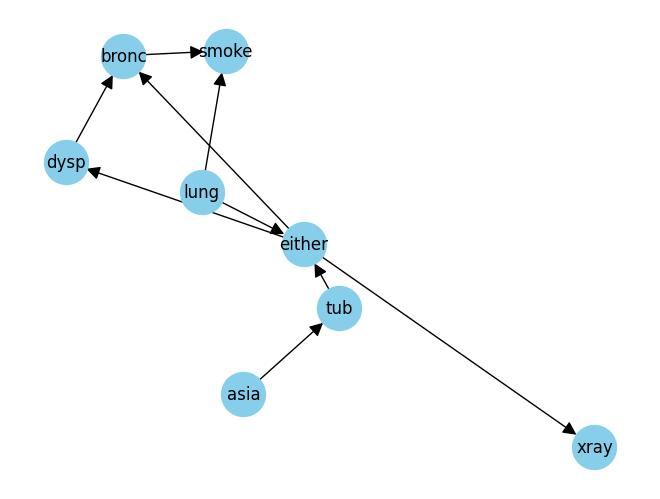

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph(best_model.edges())

pos = nx.spring_layout(graph)

nx.draw(graph, with_labels=True, node_size=1000, node_color="skyblue", pos=pos, arrowsize=20)

plt.show()